In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels as stats
import statsmodels.api as sm
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [3]:
train_df = pd.read_csv('dengue_train_engineered.csv')
test_df = pd.read_csv('dengue_test_engineered.csv')

In [4]:
train_df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,optimal_temp,optimal_humidity,optimal_breeding,ndvi_avg,reanalysis_air_temp_k_anomaly,reanalysis_relative_humidity_percent_anomaly,precipitation_amt_mm_anomaly,reanalysis_specific_humidity_g_per_kg_anomaly,precipitation_amt_mm_log,station_precip_mm_log
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,-1.275676,...,0,0,0,0.150606,-0.952615,-1.420812,-21.706000,-1.282393,2.596746,2.833213
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,-0.732817,...,0,0,0,0.157479,-0.481570,-0.199542,-1.742667,-0.423144,3.170526,2.261763
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,-0.248251,...,0,0,0,0.133315,-0.025989,0.697426,0.603333,0.308602,3.570659,3.747148
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,-0.073370,...,0,0,0,0.209286,-0.230260,-0.075571,-39.867333,-0.226653,2.794839,1.609438
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,0.378405,...,0,0,0,0.239235,0.110515,-0.183972,-58.974000,-0.025925,2.142416,1.916923


# Running XGBRegressor as Baseline model

1. Define the model's training function
2. Train models for each city
3. Check performance metrics for each of the models
4. Visualize feature importance and other visuals
5. Begin feature selection process, and revisit feature engineering
6. Run models again

In [17]:
def train_evaluate_model(city_name):
    city_train = train_df[train_df['city'] == city_name].copy()

    exclude_cols = ['city', 'week_start_date', 'total_cases']
    feature_cols = [col for col in city_train.columns if col not in exclude_cols]

    X = city_train[feature_cols]
    y = city_train['total_cases']

    tscv = TimeSeriesSplit(n_splits=5)  #<--- doing a time series split for cross-validation

    cv_scores_rmse = []
    cv_scores_mae = []

    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
    )
    
    last_X_test = None
    last_y_test = None
    last_y_pred = None

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train,
                  eval_set=[(X_test, y_test)],
                  verbose=False)

        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        cv_scores_rmse.append(rmse)
        cv_scores_mae.append(mae)
        
        last_X_test = X_test
        last_y_test = y_test
        last_y_pred = y_pred

    final_model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
    )

    final_model.fit(X, y)

    importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    return {
        'model': final_model,
        'cv_rmse': np.mean(cv_scores_rmse),
        'cv_mae': np.mean(cv_scores_mae),
        'importance': importance.head(20),
        'last_X_test': last_X_test,
        'last_y_test': last_y_test,
        'last_y_pred': last_y_pred
    }

In [18]:
# train models for each city
sj_results = train_evaluate_model('sj')
iq_results = train_evaluate_model('iq')

In [19]:
print(f"San Juan model: CV MAE = {sj_results['cv_mae']:.2f}")
print(f"Iquitos model: CV MAE = {iq_results['cv_mae']:.2f}")

San Juan model: CV MAE = 13.21
Iquitos model: CV MAE = 5.80


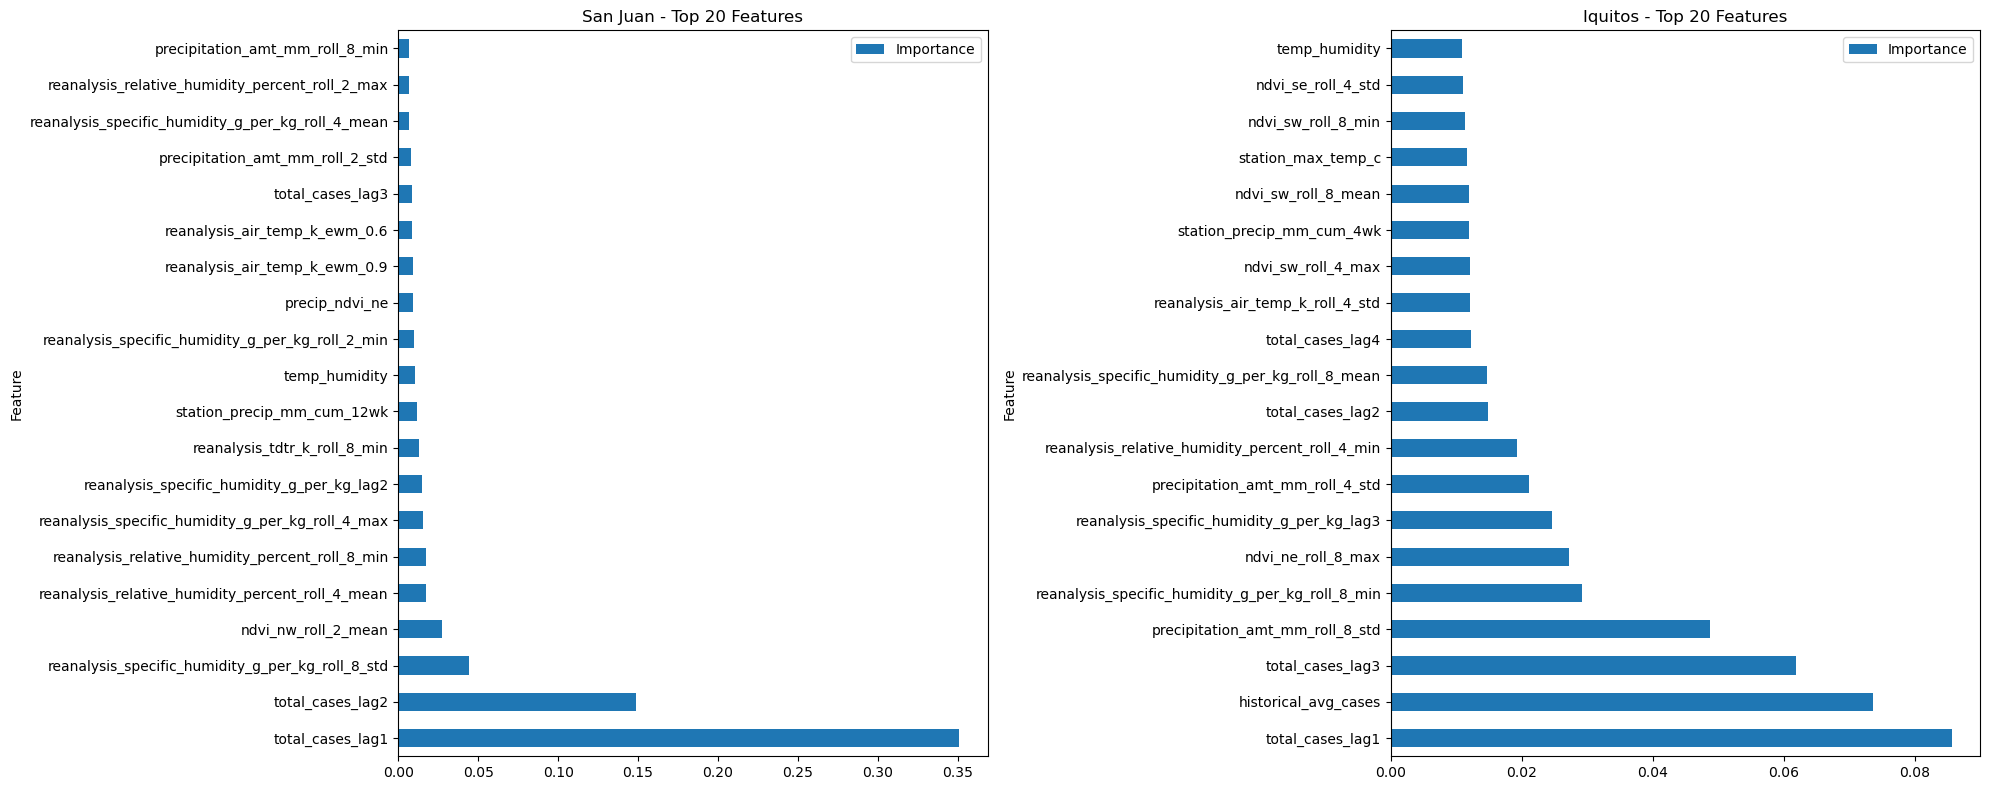

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sj_importance = sj_results['importance']
sj_importance.head(20).plot.barh(x='Feature', y='Importance', ax=ax1)
ax1.set_title('San Juan - Top 20 Features')

iq_importance = iq_results['importance']
iq_importance.head(20).plot.barh(x='Feature', y='Importance', ax=ax2)
ax2.set_title('Iquitos - Top 20 Features')

plt.tight_layout()
plt.show()

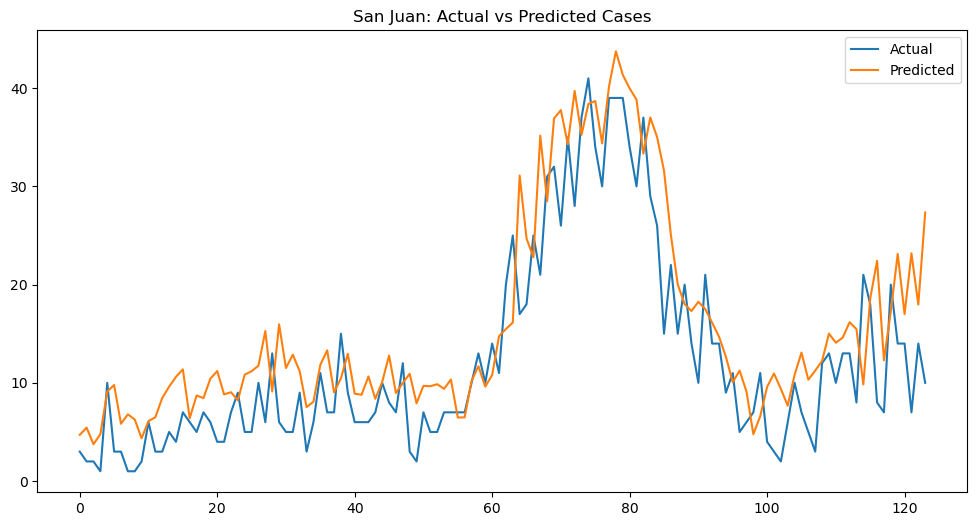

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(sj_results['last_y_test'].values, label='Actual')
plt.plot(sj_results['last_y_pred'], label='Predicted')
plt.title('San Juan: Actual vs Predicted Cases')
plt.legend()
plt.show()

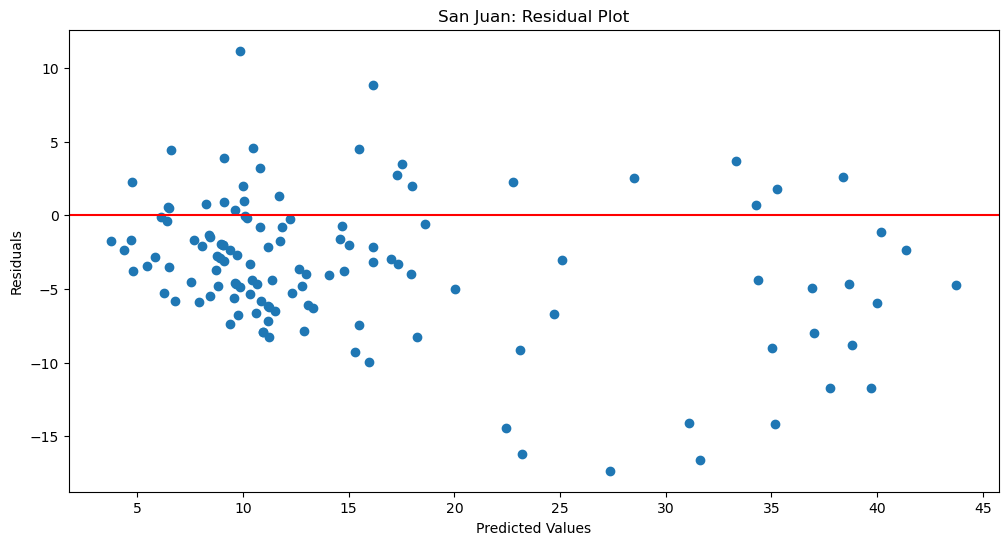

In [23]:
residuals = sj_results['last_y_test'] - sj_results['last_y_pred']
plt.figure(figsize=(12, 6))
plt.scatter(sj_results['last_y_pred'], residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('San Juan: Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

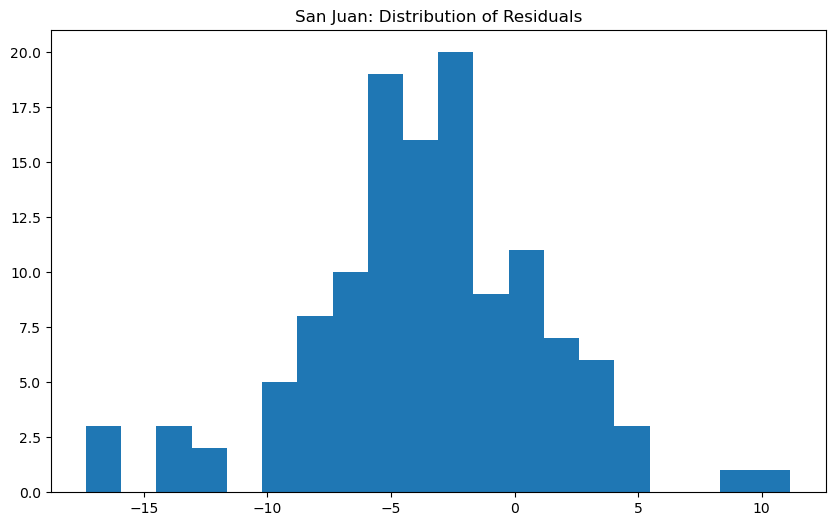

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20)
plt.title('San Juan: Distribution of Residuals')
plt.show()

In [25]:
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat}")
# Values close to 2 indicate no autocorrelation
# Values toward 0 indicate positive autocorrelation
# Values toward 4 indicate negative autocorrelation

Durbin-Watson statistic: 1.3819000931504621
